In [2]:
%pylab inline
!pip install natsort

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from natsort import natsorted
from PIL import Image

torch.manual_seed(1)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
"""
def unzip(path, name_folder):
    with ZipFile(path, 'r') as zipObj:
        # Extract all the contents of zip file in different directory
        zipObj.extractall(name_folder)
        print('Done :)')
unzip('horse2zebra.zip', 'images_zebras')
"""

"\ndef unzip(path, name_folder):\n    with ZipFile(path, 'r') as zipObj:\n        # Extract all the contents of zip file in different directory\n        zipObj.extractall(name_folder)\n        print('Done :)')\nunzip('horse2zebra.zip', 'images_zebras')\n"

In [4]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_c, out_c, kernel, stride, padding):
        super().__init__()
        self.convos = torch.nn.Sequential(
            torch.nn.Conv2d(in_c, out_c, kernel, stride, padding, padding_mode = "reflect"),
            torch.nn.InstanceNorm2d(out_c),
            torch.nn.ReLU(),
        )
    def forward(self, x):
        result = self.convos(x)
        return result

class LeakyConvBlock(torch.nn.Module):
    def __init__(self, in_c, out_c, kernel, stride, padding):
        super().__init__()
        self.convos = torch.nn.Sequential(
            torch.nn.Conv2d(in_c, out_c, kernel, stride, padding, padding_mode = "reflect"),
            torch.nn.InstanceNorm2d(out_c),
            torch.nn.LeakyReLU(0.2),
        )
    def forward(self, x):
        result = self.convos(x)
        return result
    
class TransposeBlock(torch.nn.Module):
    def __init__(self, in_c, out_c, kernel, stride, padding, out_pad):
        super().__init__()
        self.convos = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_c, out_c, kernel, stride, padding, out_pad),
            torch.nn.InstanceNorm2d(out_c),
            torch.nn.ReLU(),
        )
    def forward(self, x):
        result = self.convos(x)
        return result

In [5]:
class Residual(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convos = torch.nn.Sequential(
            torch.nn.Conv2d(256, 256, 3, 1, 1, padding_mode = "reflect"),
            torch.nn.InstanceNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, 1, 1, padding_mode = "reflect"),
            torch.nn.InstanceNorm2d(256),
        )
    def forward(self, x):
        result = x + self.convos(x)
        return result

In [6]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3 256 256
        self.down = torch.nn.Sequential(
            ConvBlock(3, 64, 7, 1, 3),
            ConvBlock(64, 128, 3, 2, 1),
            ConvBlock(128, 256, 3, 2, 1),
        )
        self.residuals = torch.nn.Sequential(
            *[Residual() for x in range(9)]
        )
        self.up = torch.nn.Sequential(
            TransposeBlock(256, 128, 3, 2, 1, 1),
            TransposeBlock(128, 64, 3, 2, 1, 1),
            torch.nn.Conv2d(64, 3, 7, 1, 3),
        )
        # 3 256 256
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        x = self.down(x)
        x = self.residuals(x)
        x = self.up(x)
        return self.tanh(x)

In [7]:
class Discriminator(torch.nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        model = [   torch.nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    torch.nn.LeakyReLU(0.2, inplace=True) ]

        model += [  torch.nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    torch.nn.InstanceNorm2d(128), 
                    torch.nn.LeakyReLU(0.2, inplace=True) ]

        model += [  torch.nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    torch.nn.InstanceNorm2d(256), 
                    torch.nn.LeakyReLU(0.2, inplace=True) ]

        model += [  torch.nn.Conv2d(256, 512, 4, padding=1),
                    torch.nn.InstanceNorm2d(512), 
                    torch.nn.LeakyReLU(0.2, inplace=True) ]

        model += [torch.nn.Conv2d(512, 1, 4, padding=1)]

        self.model = torch.nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return torch.nn.functional.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    """
        Returns summer and winter images
    """
    def __init__(self, first_dir, second_dir, transform):
        self.first_dir = first_dir
        self.second_dir = second_dir
        self.transform = transform
        first_imgs, second_imgs = os.listdir(first_dir), os.listdir(second_dir)
        self.total_first = natsorted(first_imgs)
        self.total_second = natsorted(second_imgs)

    def __len__(self):
        return len(self.total_first)
    
    def __getitem__(self, idx):
        img_loc1 = os.path.join(self.first_dir, self.total_first[idx])
        img_loc2 = os.path.join(self.second_dir, self.total_second[idx])
        image1 = Image.open(img_loc1).convert("RGB")
        image2 = Image.open(img_loc2).convert("RGB")
        
        image1, image2 = self.transform(image1), self.transform(image2)
        return image1, image2

In [9]:
std_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
ds = CustomDataset('images_zebras/horse2zebra/trainA', 'images_zebras/horse2zebra/trainB', transform=std_transform)
images_loader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle = True, drop_last = True)
print(len(ds))

1067


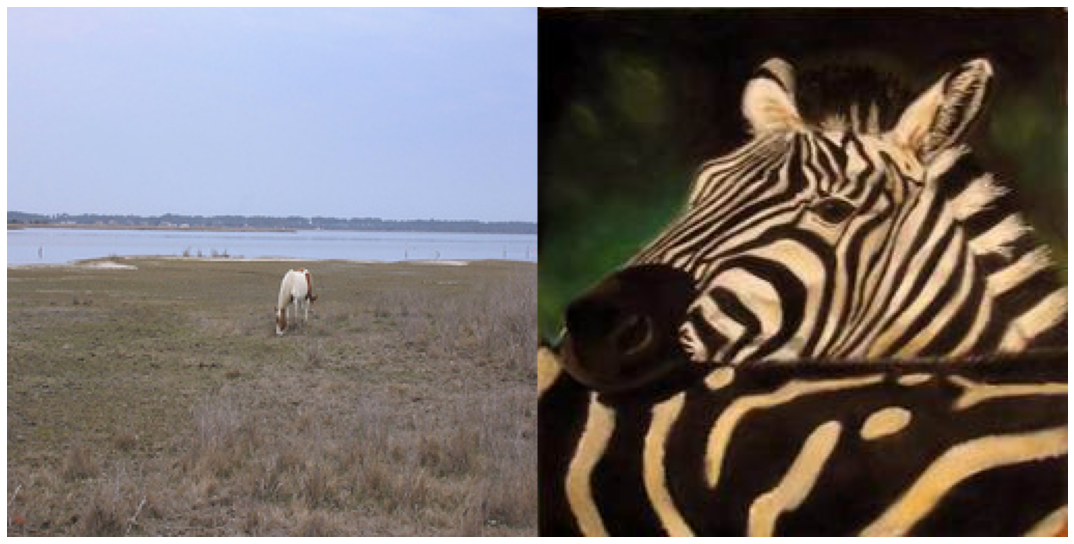

In [10]:
def concat_img(imgs):
    figsize(19,19)
    figure()
    imgs = (imgs + 1) / 2
    imgs = imgs.movedim((0, 1, 2, 3), (0, 3, 1, 2)).detach().cpu().numpy() 
    axs = imshow(np.concatenate(imgs.tolist(), axis=1))
    plt.axis('off')
    plt.show()
    
summer, winter = next(iter(images_loader))
concat_img(torch.cat((summer[:4], winter[:4]), 0))

In [16]:
import itertools
LAMBDA = 10
LR = 2e-4

G = Generator().cuda()
F = Generator().cuda()
Dx = Discriminator(3).cuda()
Dy = Discriminator(3).cuda()
g_lr = LR
d_lr = LR

g_optim = torch.optim.Adam(itertools.chain(G.parameters(), F.parameters()),
                                lr=LR, betas=(0.5, 0.999))
dx_optim = torch.optim.Adam(Dx.parameters(), lr=LR, betas=(0.5, 0.999))
dy_optim= torch.optim.Adam(Dy.parameters(), lr=LR, betas=(0.5, 0.999))

L1 = torch.nn.L1Loss()
MSE= torch.nn.MSELoss()

c_params = sum(p.numel() for p in Dx.parameters())
g_params = sum(p.numel() for p in G.parameters())
print("Dx millions {:.1f} G millions {:.1f}".format(c_params / 1e6, g_params / 1e6))


PATH = 'cycle_dx_v1'
checkpoint = torch.load(PATH)
Dx.load_state_dict(checkpoint['model_state_dict'])
dx_optim.load_state_dict(checkpoint['optimizer_state_dict'])
iters = checkpoint['iters']

PATH = 'cycle_dy_v1'
checkpoint = torch.load(PATH)
Dy.load_state_dict(checkpoint['model_state_dict'])
dy_optim.load_state_dict(checkpoint['optimizer_state_dict'])
iters = checkpoint['iters']

PATH = 'cycle_g_v1'
checkpoint = torch.load(PATH)
G.load_state_dict(checkpoint['model_state_dict'])
g_optim.load_state_dict(checkpoint['optimizer_state_dict'])
iters = checkpoint['iters']

PATH = 'cycle_f_v1'
checkpoint = torch.load(PATH)
F.load_state_dict(checkpoint['model_state_dict'])
g_optim.load_state_dict(checkpoint['optimizer_state_dict'])
iters = checkpoint['iters']

/tmp/ipykernel_130/1169924577.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  c_params = sum(p.numel() for p in Dx.parameters())
/tmp/ipykernel_130/1169924577.py:21: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  g_params = sum(p.numel() for p in G.parameters())


Dx millions 2.8 G millions 11.4


In [12]:
def save_models():
    torch.save({
            'epoch': i,
            'model_state_dict': G.state_dict(),
            'optimizer_state_dict': g_optim.state_dict(),
            'loss': g_loss,
            'iters': iters,
            }, './cycle_g_v1')
    torch.save({
            'epoch': i,
            'model_state_dict': F.state_dict(),
            'optimizer_state_dict': g_optim.state_dict(),
            'loss': g_loss,
            'iters': iters,
            }, './cycle_f_v1')
    torch.save({
            'epoch': i,
            'model_state_dict': Dx.state_dict(),
            'optimizer_state_dict': dx_optim.state_dict(),
            'loss': dx_loss,
            'iters': iters,
            }, './cycle_dx_v1')
    torch.save({
            'epoch': i,
            'model_state_dict': Dy.state_dict(),
            'optimizer_state_dict': dy_optim.state_dict(),
            'loss': dy_loss,
            'iters': iters,
            }, './cycle_dy_v1')

In [13]:
cycle_loss_list = []
adversarial_loss_list = []

dx_loss: 0.139, dy_loss: 0.021, g_loss: 4.238 cycle_loss 2.450 adversarial_loss 1.788 epoch 0 iter 0


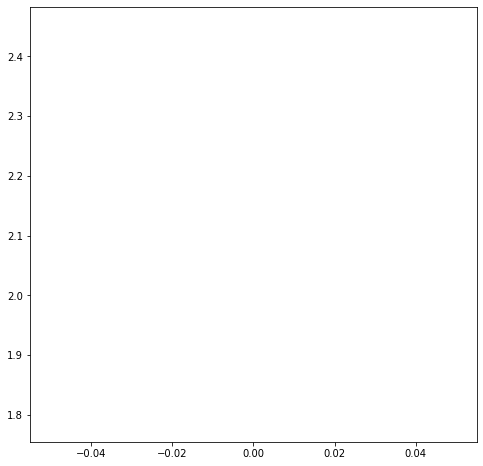

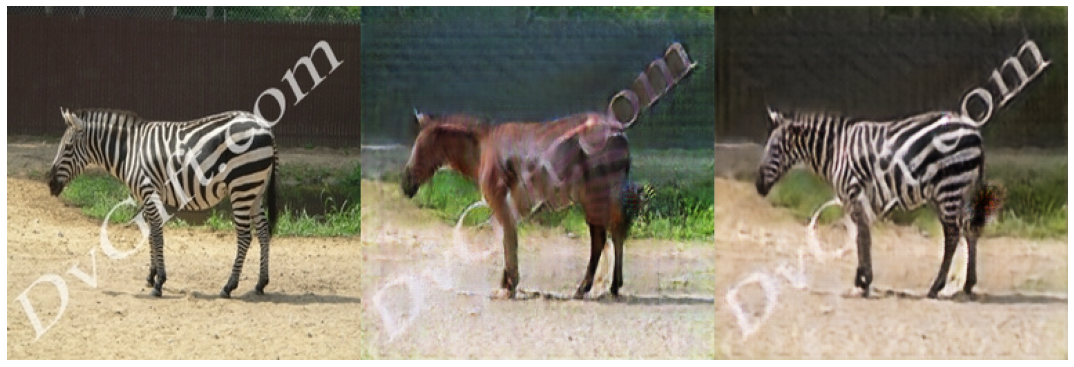

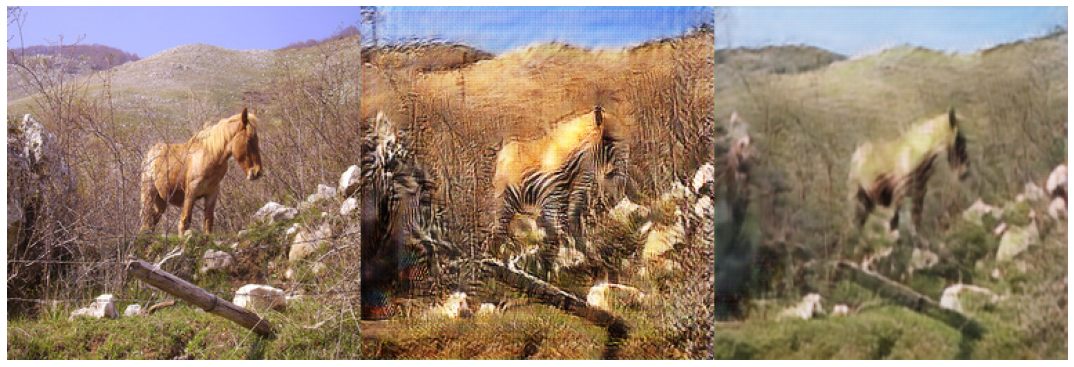

KeyboardInterrupt: 

In [17]:
# Train discriminators
iters = 0
epochs = 50

for i in range(epochs):
    G.train() 
    F.train()
    Dx.train() 
    Dy.train()
    for batch_idx, (x, y) in enumerate(images_loader):
        x, y = x.cuda(), y.cuda()
        
        # Train dx
        dx_optim.zero_grad()
        
        real_dx = Dx(x) 
        fake_dx = Dx(F(y).detach())
         
        dx_loss = (MSE(real_dx, torch.ones_like(real_dx)) + MSE(fake_dx, torch.zeros_like(fake_dx))) * 0.5
        
        dx_loss.backward()
        dx_optim.step()
        
        # Train dx
        dy_optim.zero_grad()
        
        real_dy = Dy(y) 
        fake_dy = Dy(G(x).detach())
         
        dy_loss = (MSE(real_dy, torch.ones_like(real_dy)) + MSE(fake_dy, torch.zeros_like(fake_dy))) * 0.5
        
        dy_loss.backward()
        dy_optim.step()
        
        # Train generators
        g_optim.zero_grad()
        
        fake_x = F(y) 
        fake_y = G(x)
        
        pred_x = Dx(fake_x)
        pred_y = Dy(fake_y)
        
        loss_x = MSE(pred_x, torch.ones_like(pred_x))
        loss_y = MSE(pred_y, torch.ones_like(pred_y))
        adversarial_loss = loss_x + loss_y
        
        cycle_x = F(fake_y)
        cycle_y = G(fake_x)
        cycle_loss = LAMBDA * (L1(x, cycle_x) + L1(y, cycle_y))
        
        g_loss = loss_x + loss_y + cycle_loss
        g_loss.backward()
        g_optim.step()
        
        cycle_loss_list.append(cycle_loss.cpu().detach().numpy())
        adversarial_loss_list.append(adversarial_loss.cpu().detach().numpy())
        if (batch_idx % 500 == 0):
            print('dx_loss: {:.3f}, dy_loss: {:.3f}, g_loss: {:.3f} cycle_loss {:.3f} adversarial_loss {:.3f} epoch {:} iter {:}'.format(dx_loss, dy_loss, g_loss, cycle_loss, adversarial_loss, i, iters))
            figsize(8,8)
            plt.plot(cycle_loss_list)
            plt.plot(adversarial_loss_list)
            plt.show()
        if (batch_idx % 500 == 0):
            concat_img(torch.cat((y[:1], fake_x[:1], cycle_y[:1]), 0))
            concat_img(torch.cat((x[:1], fake_y[:1], cycle_x[:1]), 0))
            plt.show()
        if (batch_idx % 500 == 0):
            save_models()
        iters += 1

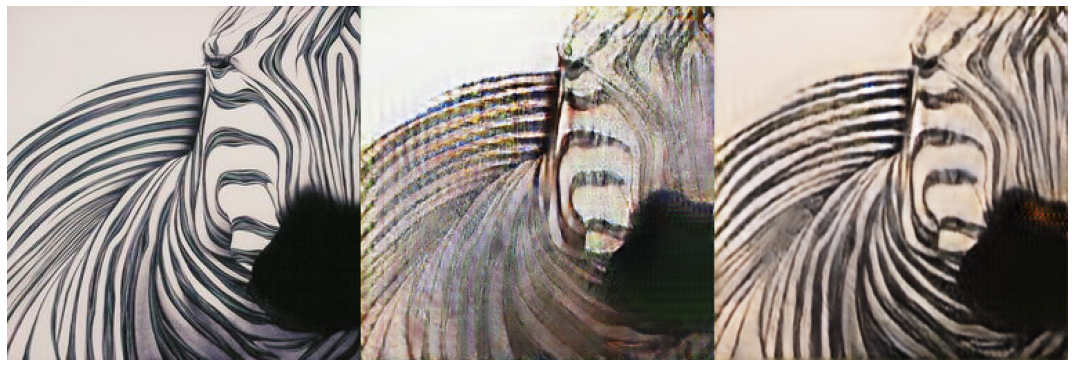

In [ ]:
G.eval()
F.eval()
for i in range(5):
    x, y = next(iter(images_loader))
    x, y = x.cuda(), y.cuda()
    
    fake_x = F(y) 
    fake_y = G(x)
    
    cycle_x = F(fake_y)
    cycle_y = G(fake_x)
    
    concat_img(torch.cat((y[:1], fake_x[:1], cycle_y[:1]), 0))
    concat_img(torch.cat((x[:1], fake_y[:1], cycle_x[:1]), 0))
    plt.show()